# Projet de courbe de taux

### Auteur : GANIYU Isaac

# Importation des packages et des données

In [36]:
!pip install openpyxl


[notice] A new release of pip available: 22.3 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [37]:
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

In [38]:
data = pd.read_excel("Taux_BBG.xlsx")
data

,Term,Unit,Ticker,Bid,Ask,Spread,Bid Spr Val,Ask Spr Val,Final Bid Rate,Final Ask Rate,Rate Type,Daycount,Freq
0,6,MO,EUR006M,3.832000,3.832000,NaN,0,0,3.832000,3.832000,Cash Rates,ACT/360,0
1,7,MO,EUFR0AG,3.718854,3.739146,NaN,0,0,3.718854,3.739146,Serial FRAs,ACT/360,0
2,8,MO,EUFR0BH,3.568535,3.589465,NaN,0,0,3.568535,3.589465,Serial FRAs,ACT/360,0
3,9,MO,EUFR0CI,3.401652,3.422348,NaN,0,0,3.401652,3.422348,Serial FRAs,ACT/360,0
4,10,MO,EUFR0DJ,3.244446,3.265554,NaN,0,0,3.244446,3.265554,Serial FRAs,ACT/360,0
5,11,MO,EUFR0EK,3.082550,3.103450,NaN,0,0,3.082550,3.103450,Serial FRAs,ACT/360,0
6,12,MO,EUFR0F1,2.946000,2.966000,NaN,0,0,2.946000,2.966000,Serial FRAs,ACT/360,0
7,15,MO,EUFR0I1C,2.594640,2.615360,NaN,0,0,2.594640,2.615360,Serial FRAs,ACT/360,0
8,18,MO,EUFR011F,2.343705,2.364295,NaN,0,0,2.343705,2.364295,Serial FRAs,ACT/360,0
9,2,YR,EUSA2,2.881192,2.900208,NaN,0,0,2.881192,2.900208,Swap Rates,30U/360,1


# Construction de la courbe de taux 

Pour construire la courbe de taux nous allons procéder en 3 étapes principales: 

- Construction de la courbe à court terme (term < 6 mois): Nous utiliserons les cash rates c'est à dire les taux interbancaires correspondant au Rate Type "Cash Rates" dans nos données

- Construction de la courbe à moyen terme (6 mois < term < 2 ans): Nous utiliserons les Forward rates correspondant au Rate Type "Serial FRAs" dans nos données

- Construction de la courbe à long terme (term >= 2 ans): Nous utiliserons les swaps de taux correspondant au Rate Type "Swap Rates" dans nos données

Nous diviserons notre base de données en sous base et les traiterons de manière adéquate puis nous rassemblerons les résultats sur les différentes sous bases.

Il nous faut dans un premier temps:
-  créer la ligne initiale de term 0 et de taux qui vaut 1

- Créer la colonne Mid qui est la moyenne arithmétique des colonnes "Bid" et "Ask". C'est cette colonne qui sera utilisée par la suite pour obtenir la valeur du taux.

- Créer la sous base data_months qui sépare les term en mois des term en années. Cette sous base sera traitée différemment.

In [39]:
columns = data.columns
columns

Index(['Term', 'Unit', 'Ticker', 'Bid', 'Ask', 'Spread', 'Bid Spr Val',
       'Ask Spr Val', 'Final Bid Rate', 'Final Ask Rate', 'Rate Type',
       'Daycount', 'Freq'],
      dtype='object')

In [40]:
row0 = {
    "Term": 0,
    "Unit": "MO",
    "Ticker": None,
    "Bid": None,
    "Ask": None,
    "Bid Spr Val": None,
    "Ask Spr Val": None,
    "Final Bid Rate": None,
    "Final Ask Rate": None,
    "Rate Type": None,
    "Daycount": None,
    "Freq": None, 
    "Mid": None
}
data.reset_index(drop=True, inplace=True)
data["Mid"] = [(data["Bid"].iloc[i]+data['Ask'].iloc[i])/2 for i in range(len(data))] # Création de la colonne Mid
data = pd.concat([data, pd.DataFrame([row0], index=[1])], axis= 0, ignore_index=True) # Ajout de la première ligne de term 0
data_months = data[data["Unit"]=="MO"] # Création de la sous base data_months

C:\Users\HP\AppData\Local\Temp\ipykernel_13156\1054839012.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, pd.DataFrame([row0], index=[1])], axis= 0, ignore_index=True) # Ajout de la première ligne de term 0


In [41]:
data_months = data_months.sort_values(by='Term')
data_months

,Term,Unit,Ticker,Bid,Ask,Spread,Bid Spr Val,Ask Spr Val,Final Bid Rate,Final Ask Rate,Rate Type,Daycount,Freq,Mid
26,0,MO,None,NaN,NaN,NaN,None,None,NaN,NaN,None,None,None,NaN
0,6,MO,EUR006M,3.832000,3.832000,NaN,0,0,3.832000,3.832000,Cash Rates,ACT/360,0,3.832
1,7,MO,EUFR0AG,3.718854,3.739146,NaN,0,0,3.718854,3.739146,Serial FRAs,ACT/360,0,3.729
2,8,MO,EUFR0BH,3.568535,3.589465,NaN,0,0,3.568535,3.589465,Serial FRAs,ACT/360,0,3.579
3,9,MO,EUFR0CI,3.401652,3.422348,NaN,0,0,3.401652,3.422348,Serial FRAs,ACT/360,0,3.412
4,10,MO,EUFR0DJ,3.244446,3.265554,NaN,0,0,3.244446,3.265554,Serial FRAs,ACT/360,0,3.255
5,11,MO,EUFR0EK,3.082550,3.103450,NaN,0,0,3.082550,3.103450,Serial FRAs,ACT/360,0,3.093
6,12,MO,EUFR0F1,2.946000,2.966000,NaN,0,0,2.946000,2.966000,Serial FRAs,ACT/360,0,2.956
7,15,MO,EUFR0I1C,2.594640,2.615360,NaN,0,0,2.594640,2.615360,Serial FRAs,ACT/360,0,2.605
8,18,MO,EUFR011F,2.343705,2.364295,NaN,0,0,2.343705,2.364295,Serial FRAs,ACT/360,0,2.354


Maintenant nous travaillons sur la sous base data_months qui contient les terms dont l'unité est le mois. Cette dernière contient à la fois des taux cash rates et des taux forward rates.

Nous créerons à la fin de nos manipulations deux nouvelles colonnes T et B(0,T) désignant respectivement le term en année et le taux spot correspondant. La colonne "T" est simplement égale à la colonne "Term" divisée par 12 car la colonne Term est en mois dans cette sous base.

Dans un premier temps, nous stockons les valeurs de la colonne "B(0,T)" dans la liste "taux_T" qui est remplie progressivement grâce aux colonnes T1, T2 et "taux_T1". la colonne T2 correspond à la colonne T et la colonne T1 correspond à la colonne T2 à laquelle on retire la fréquence de 0.5 année (une fréquence de 6 mois). Enfin la colonne taux_T1 désigne la valeur de B(0,T1) c'est à dire le taux spot en T1. 

Le première valeur du taux_T vaut 1, il s'agit de la valeur B(0,0) du taux spot à l'instant initial. 

Nous créons une sous base data_cash de la sous base data_months. Il s'agit des lignes correspondant au taux de court term cash rates. Pour cette sous base nous utilisons la formule du taux spot à court terme: 

$B_{CT}(0, \delta) = \frac{1}{1 + \delta \cdot L \quad}$ avec $\delta$ la fréquence qui vaut ici 6 mois.

La variable taux_T est donc remplie pour les lignes correspondantes en utilisisant cette formule.

Nous créons ensuite une sous base data_FRA de la sous base data_months. Il s'agit des lignes correspondant au taux de moyen terme forward rate. Pour cette sous base il faut dans un premier temps interpoler les valeurs de B(0,T1) correspondant aux lignes de T1 dans data_FRA. La fonction d'interpolation se sert des valeurs observées jusque là de taux_T (B(0,T)). Nous créons deux fonctions d'interpolation car il faut faire attention à pouvoir interpoler grâce aux valeurs observées. En particulier les valeurs de T1 à utiliser pour l'interpolation doivent se trouver dans la plage de données déjà observée pour T. Cette manoeuvre nous permet d'obtenir les valeurs de B(0,T1).

Une fois que nous obtenons les valeurs interpolées de B(0,T1) stockées dans taux_T1, nous pouvons calculer les valeurs suivantes de B(0,T) (stockées dans taux_T). Il s'agit des valeurs de moyen terme et elles sont calculées grâce à la formule: 

$B_{MT}(0, T) = \frac{B(0,T1)}{1 + \delta \cdot F}$



In [42]:
freq = 6
T = [term/12 for term in data_months["Term"]]
data_months["T"] = T
T2 = T
T1 = [term-freq/12 for term in T2]
taux_T = [1] # B(0,T)
taux_T1 = [] # B(0,T1)
data_cash = data_months[data_months["Rate Type"]== "Cash Rates"]

# calcul de B(0,T) à court terme 
for i in range(len(data_cash)):
    taux_T.append(1/(1+freq*data_cash["Mid"].iloc[i]/1200)) # On divise par 1200= 12*100 car la fréquence doit être divisée par 12 et le taux par 100

# calcul de B(0,T) à moyen terme 

data_FRA = data_months[data_months["Rate Type"]== "Serial FRAs"]
interp_func = interpolate.interp1d(T[:len(taux_T)], taux_T) #fonction d'interpolation de B(0,T) en fonction de T

T1_interpol = [tenor for tenor in T1[len(data_cash)+1:len(data_cash)+1+len(data_FRA)] if tenor<= T[len(taux_T)-1]] # valeurs de T1 à utiliser pour l'interpolation

taux_T1+=[interp_func(t) for t in T1_interpol] # valeurs interpolées de B(0,T1)

current_n = len(taux_T1)

taux_T+= [taux_T1[i]/(1+freq*data_months["Mid"].iloc[len(data_cash)+1+i]/1200) for i in range(current_n)]

interp_func2 = interpolate.interp1d(T[:len(taux_T)], taux_T) # on met à jour la fonction d'interpolation grâce aux nouvelles valeurs observées de taux_T
T1_interpol2 = [t for t in T1 if t>T1_interpol[-1] and t<T[len(taux_T)]]

taux_T1+= [interp_func2(t) for t in T1_interpol2] # nouvelles valeurs interpolées de B(0,T1)

taux_T+= [taux_T1[i]/(1+freq*data_months["Mid"].iloc[len(data_cash)+1+i]/1200) for i in range(current_n, len(taux_T1))]



In [43]:
data_months["T"] = T
data_months["B(0,T)"]= taux_T
data_months


,Term,Unit,Ticker,Bid,Ask,Spread,Bid Spr Val,Ask Spr Val,Final Bid Rate,Final Ask Rate,Rate Type,Daycount,Freq,Mid,T,"B(0,T)"
26,0,MO,None,NaN,NaN,NaN,None,None,NaN,NaN,None,None,None,NaN,0.000000,1.000000
0,6,MO,EUR006M,3.832000,3.832000,NaN,0,0,3.832000,3.832000,Cash Rates,ACT/360,0,3.832,0.500000,0.981200
1,7,MO,EUFR0AG,3.718854,3.739146,NaN,0,0,3.718854,3.739146,Serial FRAs,ACT/360,0,3.729,0.583333,0.978620
2,8,MO,EUFR0BH,3.568535,3.589465,NaN,0,0,3.568535,3.589465,Serial FRAs,ACT/360,0,3.579,0.666667,0.976263
3,9,MO,EUFR0CI,3.401652,3.422348,NaN,0,0,3.401652,3.422348,Serial FRAs,ACT/360,0,3.412,0.750000,0.973984
4,10,MO,EUFR0DJ,3.244446,3.265554,NaN,0,0,3.244446,3.265554,Serial FRAs,ACT/360,0,3.255,0.833333,0.971653
5,11,MO,EUFR0EK,3.082550,3.103450,NaN,0,0,3.082550,3.103450,Serial FRAs,ACT/360,0,3.093,0.916667,0.969343
6,12,MO,EUFR0F1,2.946000,2.966000,NaN,0,0,2.946000,2.966000,Serial FRAs,ACT/360,0,2.956,1.000000,0.966909
7,15,MO,EUFR0I1C,2.594640,2.615360,NaN,0,0,2.594640,2.615360,Serial FRAs,ACT/360,0,2.605,1.250000,0.961461
8,18,MO,EUFR011F,2.343705,2.364295,NaN,0,0,2.343705,2.364295,Serial FRAs,ACT/360,0,2.354,1.500000,0.955661


### Représentation de la courbe de taux spot sur le court et le moyen terme (term < 2 ans)

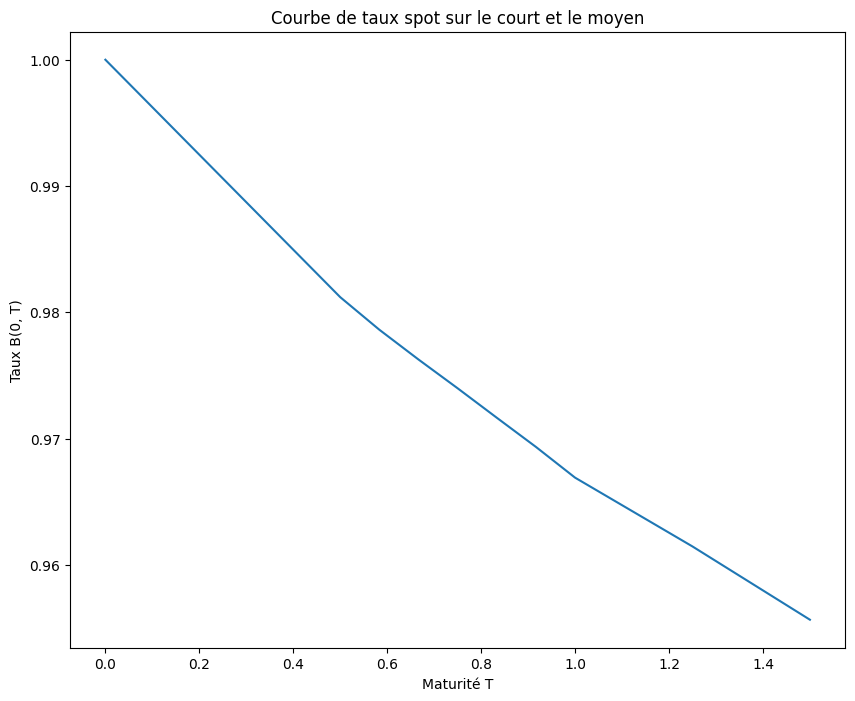

In [44]:
plt.figure(figsize = (10,8))
plt.plot(data_months["T"], data_months["B(0,T)"])
plt.xlabel("Maturité T")
plt.ylabel("Taux B(0, T)")
plt.title('Courbe de taux spot sur le court et le moyen')
plt.show()

Maintenant nous travaillons sur la dernière grande étape de la construction de notre courbe de taux c'est à dire le long terme. Nous créons une nouvelle sous base data_years qui regroupe les term dont l'unité est l'année. Cette sous base ne contient que les taux de long terme swap rates (term >= 2 ans).

In [45]:
data_years = data[data["Unit"]=="YR"]
data_years

,Term,Unit,Ticker,Bid,Ask,Spread,Bid Spr Val,Ask Spr Val,Final Bid Rate,Final Ask Rate,Rate Type,Daycount,Freq,Mid
9,2,YR,EUSA2,2.881192,2.900208,NaN,0,0,2.881192,2.900208,Swap Rates,30U/360,1,2.89070
10,3,YR,EUSA3,2.659052,2.678948,NaN,0,0,2.659052,2.678948,Swap Rates,30U/360,1,2.66900
11,4,YR,EUSA4,2.574876,2.581124,NaN,0,0,2.574876,2.581124,Swap Rates,30U/360,1,2.57800
12,5,YR,EUSA5,2.540222,2.544778,NaN,0,0,2.540222,2.544778,Swap Rates,30U/360,1,2.54250
13,6,YR,EUSA6,2.531604,2.536396,NaN,0,0,2.531604,2.536396,Swap Rates,30U/360,1,2.53400
14,7,YR,EUSA7,2.539071,2.543929,NaN,0,0,2.539071,2.543929,Swap Rates,30U/360,1,2.54150
15,8,YR,EUSA8,2.551923,2.556977,NaN,0,0,2.551923,2.556977,Swap Rates,30U/360,1,2.55445
16,9,YR,EUSA9,2.569489,2.573911,NaN,0,0,2.569489,2.573911,Swap Rates,30U/360,1,2.57170
17,10,YR,EUSA10,2.589432,2.594569,NaN,0,0,2.589432,2.594569,Swap Rates,30U/360,1,2.59200
18,11,YR,EUSA11,2.611082,2.617118,NaN,0,0,2.611082,2.617118,Swap Rates,30U/360,1,2.61410


Nous avons des terms allant de 2 à 50 ans mais de manière discontinue. Nous créons donc les lignes intermédiaires de sorte à obtenir des taux allant de 2 à 50 ans par pas de 1 an. Nous interpolons ensuite les valeurs de la colonne 'Mid' de sorte à avoir les taux interpolés pour les nouvelles lignes obtenues.

In [46]:
max_term = data_years['Term'].max()
min_term = data_years['Term'].min()

all_terms_df = pd.DataFrame({'Term': range(min_term, max_term + 1)}) # colonne avec tous les terms

# Fusionner le DataFrame original avec la colonne contenant tous les terms
data_years = pd.merge(all_terms_df, data_years, on='Term', how='left')

# Utiliser une interpolation pour remplir les valeurs de la colonne "Mid"
data_years['Mid'] = data_years['Mid'].interpolate()

# remplir la colonne Unit
data_years['Unit'] = ['YR' for _ in range(len(data_years))]

data_years

,Term,Unit,Ticker,Bid,Ask,Spread,Bid Spr Val,Ask Spr Val,Final Bid Rate,Final Ask Rate,Rate Type,Daycount,Freq,Mid
0,2,YR,EUSA2,2.881192,2.900208,NaN,0,0,2.881192,2.900208,Swap Rates,30U/360,1,2.890700
1,3,YR,EUSA3,2.659052,2.678948,NaN,0,0,2.659052,2.678948,Swap Rates,30U/360,1,2.669000
2,4,YR,EUSA4,2.574876,2.581124,NaN,0,0,2.574876,2.581124,Swap Rates,30U/360,1,2.578000
3,5,YR,EUSA5,2.540222,2.544778,NaN,0,0,2.540222,2.544778,Swap Rates,30U/360,1,2.542500
4,6,YR,EUSA6,2.531604,2.536396,NaN,0,0,2.531604,2.536396,Swap Rates,30U/360,1,2.534000
5,7,YR,EUSA7,2.539071,2.543929,NaN,0,0,2.539071,2.543929,Swap Rates,30U/360,1,2.541500
6,8,YR,EUSA8,2.551923,2.556977,NaN,0,0,2.551923,2.556977,Swap Rates,30U/360,1,2.554450
7,9,YR,EUSA9,2.569489,2.573911,NaN,0,0,2.569489,2.573911,Swap Rates,30U/360,1,2.571700
8,10,YR,EUSA10,2.589432,2.594569,NaN,0,0,2.589432,2.594569,Swap Rates,30U/360,1,2.592000
9,11,YR,EUSA11,2.611082,2.617118,NaN,0,0,2.611082,2.617118,Swap Rates,30U/360,1,2.614100


la colonne T correspond directement à la colonne Term. Concernant la colonne B(0,T), nous utilisons la formule de calcul de long terme:

$B_{LT}(0, T_n) = \frac{1-S_{T_n}*PVBP_n}{1 + \delta \cdot S_{T_n}}$ 

avec : $PVBP_n = \sum_{i=1}^{n-1}{\delta \cdot B(0,T_i)}$ et $S_{T_n}$ le taux swap de la date $T_n$

la variable PVBP stocke les différentes valeurs de la PVBP qui est une somme cumulée des taux précedants multipliée par la fréquence $\delta$. Nous commençons par récupérer le taux B(0,1) à 1 an qui est la valeur initiale de PVBP.

In [47]:
T_years = data_years['Term']
data_year1 = data_months[data_months["T"]==1]

PVBP = [data_year1["B(0,T)"]] # stocke les valeurs de PVBP
taux_years_T = [] # stocke les valeurs de B(0,T)

for i in range(len(data_years)):
    taux_t = (1-data_years["Mid"][i]*PVBP[i]/100)/(1+data_years["Mid"][i]/100)
    taux_years_T.append(float(taux_t))
    PVBP.append(PVBP[-1]+taux_years_T[-1])
PVBP = PVBP[:-1]
data_years["T"] = T_years
data_years["B(0,T)"]= taux_years_T



C:\Users\HP\AppData\Local\Temp\ipykernel_13156\615515372.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  taux_years_T.append(float(taux_t))


In [48]:
data_years

,Term,Unit,Ticker,Bid,Ask,Spread,Bid Spr Val,Ask Spr Val,Final Bid Rate,Final Ask Rate,Rate Type,Daycount,Freq,Mid,T,"B(0,T)"
0,2,YR,EUSA2,2.881192,2.900208,NaN,0,0,2.881192,2.900208,Swap Rates,30U/360,1,2.890700,2,0.944740
1,3,YR,EUSA3,2.659052,2.678948,NaN,0,0,2.659052,2.678948,Swap Rates,30U/360,1,2.669000,3,0.924308
2,4,YR,EUSA4,2.574876,2.581124,NaN,0,0,2.574876,2.581124,Swap Rates,30U/360,1,2.578000,4,0.903594
3,5,YR,EUSA5,2.540222,2.544778,NaN,0,0,2.540222,2.544778,Swap Rates,30U/360,1,2.542500,5,0.882485
4,6,YR,EUSA6,2.531604,2.536396,NaN,0,0,2.531604,2.536396,Swap Rates,30U/360,1,2.534000,6,0.861058
5,7,YR,EUSA7,2.539071,2.543929,NaN,0,0,2.539071,2.543929,Swap Rates,30U/360,1,2.541500,7,0.839316
6,8,YR,EUSA8,2.551923,2.556977,NaN,0,0,2.551923,2.556977,Swap Rates,30U/360,1,2.554450,8,0.817612
7,9,YR,EUSA9,2.569489,2.573911,NaN,0,0,2.569489,2.573911,Swap Rates,30U/360,1,2.571700,9,0.795912
8,10,YR,EUSA10,2.589432,2.594569,NaN,0,0,2.589432,2.594569,Swap Rates,30U/360,1,2.592000,10,0.774232
9,11,YR,EUSA11,2.611082,2.617118,NaN,0,0,2.611082,2.617118,Swap Rates,30U/360,1,2.614100,11,0.752633


### Représentation de la courbe de taux de long terme

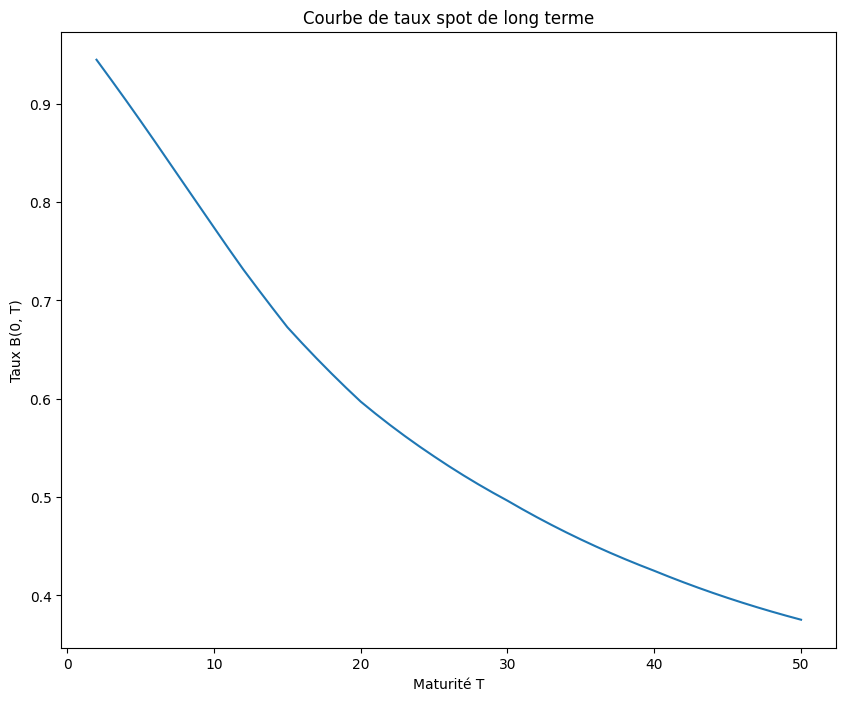

In [49]:
plt.figure(figsize = (10,8))
plt.plot(data_years["T"], data_years["B(0,T)"])
plt.xlabel("Maturité T")
plt.ylabel("Taux B(0, T)")
plt.title('Courbe de taux spot de long terme')
plt.show()

# Courbe de taux obtenue 

Nous procédons maintenant à la concaténation des sous base data_months et data_years pour obtenir l'équivalent de la base de données initiale traitée avec le calul des nouvelles colonnes T et B(0,T).

In [50]:
data_fin = pd.concat([data_months, data_years], axis= 0, ignore_index=True)
data_fin.reset_index(drop=True, inplace=True)
data_fin

,Term,Unit,Ticker,Bid,Ask,Spread,Bid Spr Val,Ask Spr Val,Final Bid Rate,Final Ask Rate,Rate Type,Daycount,Freq,Mid,T,"B(0,T)"
0,0,MO,None,NaN,NaN,NaN,None,None,NaN,NaN,None,None,None,NaN,0.000000,1.000000
1,6,MO,EUR006M,3.832000,3.832000,NaN,0,0,3.832000,3.832000,Cash Rates,ACT/360,0,3.832000,0.500000,0.981200
2,7,MO,EUFR0AG,3.718854,3.739146,NaN,0,0,3.718854,3.739146,Serial FRAs,ACT/360,0,3.729000,0.583333,0.978620
3,8,MO,EUFR0BH,3.568535,3.589465,NaN,0,0,3.568535,3.589465,Serial FRAs,ACT/360,0,3.579000,0.666667,0.976263
4,9,MO,EUFR0CI,3.401652,3.422348,NaN,0,0,3.401652,3.422348,Serial FRAs,ACT/360,0,3.412000,0.750000,0.973984
5,10,MO,EUFR0DJ,3.244446,3.265554,NaN,0,0,3.244446,3.265554,Serial FRAs,ACT/360,0,3.255000,0.833333,0.971653
6,11,MO,EUFR0EK,3.082550,3.103450,NaN,0,0,3.082550,3.103450,Serial FRAs,ACT/360,0,3.093000,0.916667,0.969343
7,12,MO,EUFR0F1,2.946000,2.966000,NaN,0,0,2.946000,2.966000,Serial FRAs,ACT/360,0,2.956000,1.000000,0.966909
8,15,MO,EUFR0I1C,2.594640,2.615360,NaN,0,0,2.594640,2.615360,Serial FRAs,ACT/360,0,2.605000,1.250000,0.961461
9,18,MO,EUFR011F,2.343705,2.364295,NaN,0,0,2.343705,2.364295,Serial FRAs,ACT/360,0,2.354000,1.500000,0.955661


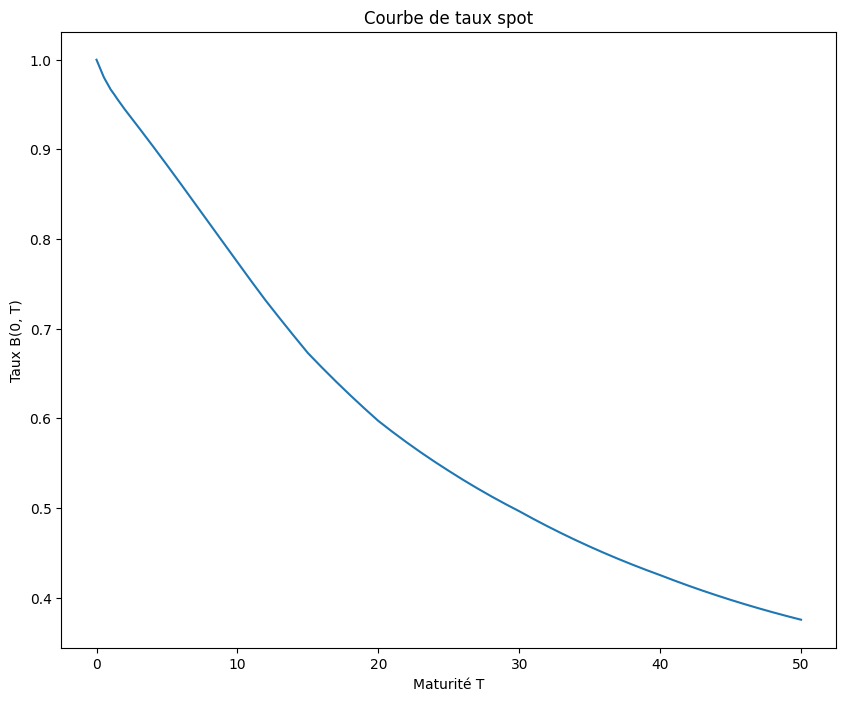

In [51]:
plt.figure(figsize=(10,8))
plt.plot(data_fin["T"], data_fin["B(0,T)"] )
plt.xlabel("Maturité T")
plt.ylabel("Taux B(0, T)")
plt.title('Courbe de taux spot')
plt.show()

Nous pouvons également représenter le rendement R(T) défini par : 

$ R(T) = \frac{ln(B(0,T))}{T}$

C:\Users\HP\AppData\Local\Temp\ipykernel_13156\2144606849.py:1: RuntimeWarning: invalid value encountered in double_scalars
  data_fin['R(T)'] = [-np.log(data_fin['B(0,T)'].iloc[i])/data_fin['T'].iloc[i] for i in range(len(data_fin))]


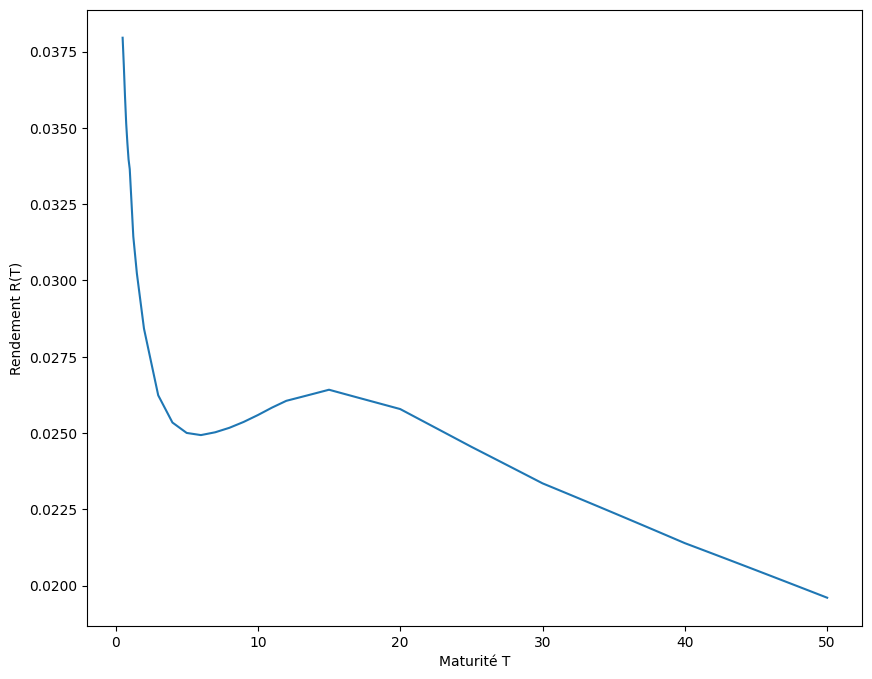

In [52]:
data_fin['R(T)'] = [-np.log(data_fin['B(0,T)'].iloc[i])/data_fin['T'].iloc[i] for i in range(len(data_fin))]

plt.figure(figsize = (10,8))
plt.plot(data_fin["T"], data_fin["R(T)"])
plt.xlabel("Maturité T")
plt.ylabel("Rendement R(T)")
plt.show()

In [53]:
data_fin

,Term,Unit,Ticker,Bid,Ask,Spread,Bid Spr Val,Ask Spr Val,Final Bid Rate,Final Ask Rate,Rate Type,Daycount,Freq,Mid,T,"B(0,T)",R(T)
0,0,MO,None,NaN,NaN,NaN,None,None,NaN,NaN,None,None,None,NaN,0.000000,1.000000,NaN
1,6,MO,EUR006M,3.832000,3.832000,NaN,0,0,3.832000,3.832000,Cash Rates,ACT/360,0,3.832000,0.500000,0.981200,0.037958
2,7,MO,EUFR0AG,3.718854,3.739146,NaN,0,0,3.718854,3.739146,Serial FRAs,ACT/360,0,3.729000,0.583333,0.978620,0.037048
3,8,MO,EUFR0BH,3.568535,3.589465,NaN,0,0,3.568535,3.589465,Serial FRAs,ACT/360,0,3.579000,0.666667,0.976263,0.036035
4,9,MO,EUFR0CI,3.401652,3.422348,NaN,0,0,3.401652,3.422348,Serial FRAs,ACT/360,0,3.412000,0.750000,0.973984,0.035147
5,10,MO,EUFR0DJ,3.244446,3.265554,NaN,0,0,3.244446,3.265554,Serial FRAs,ACT/360,0,3.255000,0.833333,0.971653,0.034508
6,11,MO,EUFR0EK,3.082550,3.103450,NaN,0,0,3.082550,3.103450,Serial FRAs,ACT/360,0,3.093000,0.916667,0.969343,0.033968
7,12,MO,EUFR0F1,2.946000,2.966000,NaN,0,0,2.946000,2.966000,Serial FRAs,ACT/360,0,2.956000,1.000000,0.966909,0.033651
8,15,MO,EUFR0I1C,2.594640,2.615360,NaN,0,0,2.594640,2.615360,Serial FRAs,ACT/360,0,2.605000,1.250000,0.961461,0.031441
9,18,MO,EUFR011F,2.343705,2.364295,NaN,0,0,2.343705,2.364295,Serial FRAs,ACT/360,0,2.354000,1.500000,0.955661,0.030235


# Valorisation d'une obligation 

### Question 1

Dans cette section nous nous attarderons à implémenter la formule de valorisation de l'obligation suivante:

$$
P_t=\sum_1^T c \cdot B(t, i) \cdot P S(i) \cdot 1_{t<i}+B(t, T) \cdot P S(T) \cdot 1_{t<T}
$$

Avec PS : probabilité de survie donnée par :
$$
P S(i)=\exp (-s .(i-t))
$$

On suppose que la courbe de taux est déterministe, ce qui nous permet de considéré la formule:
$$
B(t, T)=B(0, T) / B(0, t)
$$

Nous commençons par implémenter la formule de calcul de B(t,T) selon l'expression mentionnée ci dessus. Notons que nous utilisons une fonction d'interpolation afin d'avoir un estimation de B(0,t) et de B(0,T) quelque soit t et T. De plus, nous utilisons un choc h afin de pouvoir choquer la courbe de taux

Nous avons également implémenté la formule de la probabilité de survie. Une fois ces deux fonctions implémentées, nous avons pu implémenter la formule de valorisation de l'obligation. Cette fonction de valorisation correspond au dirty price. Nous avons donc implémenté une fonction qui permet de calculer le clean price qui correspond à la formule:

$Clean price = Pt - c \cdot (t - E(t))$ 

Avec $E(t)$ la partie entière de t.

In [54]:
def calcul_B_i_j(i, j, data_taux, h=0):
    interp_func = interpolate.interp1d(data_taux['T'], data_taux['B(0,T)']) # Fonction d'interpolation qui se base sur les valeurs observées dans nos données
    value1 = interp_func(float(j))*np.exp(-h*float(j))
    value2 = interp_func(float(i))*np.exp(-h*float(i))
    value = value1/value2
    return value

def calcul_PS(i, s, t):
    return np.exp(-s*(i-t))

def ObligationPrice(t, c, s, T, data_taux, h=0):
    terme = 0
    for i in range(1, T+1):
        if t<i :
            terme += c*calcul_B_i_j(t, i, data_taux, h=h)*calcul_PS(i, s, t)
    if t<T:
        terme += calcul_B_i_j(t, T, data_taux, h=h)*calcul_PS(T, s, t)
    
    return terme

def CleanPrice(t, c, s, T, data_taux, h=0):
    return ObligationPrice(t, c, s, T, data_taux, h = h)-c*(t-np.floor(t))



### Question 2

#### Représentation du prix en fonction de t 

T = 10 ans

c = 3%

Spread credit s = 1%

R = 0%

Nous représentons à la fois le dirty price et le clean price

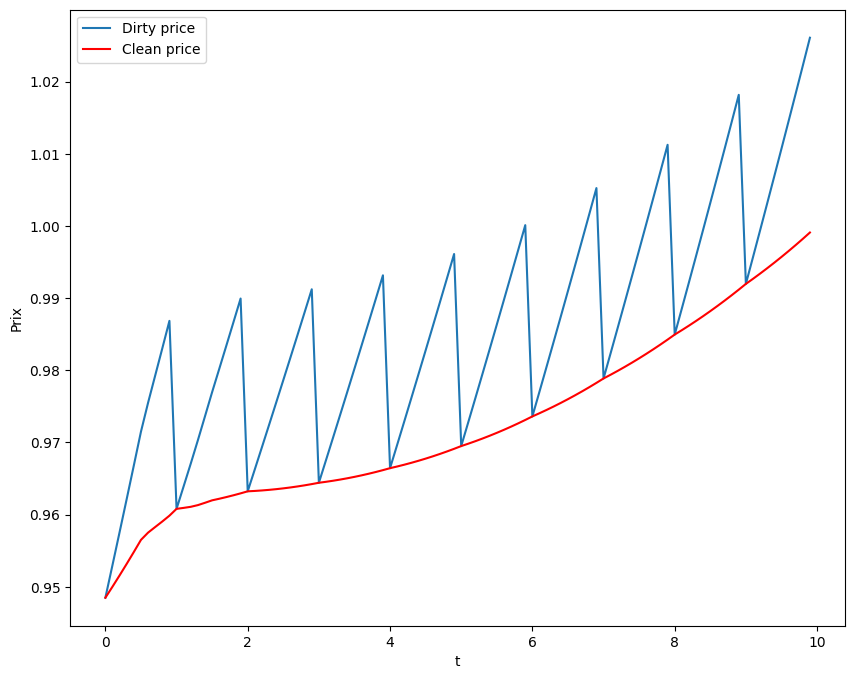

In [55]:
T = 10
c = 0.03
s = 0.01
dates = np.arange(0, T, 0.1) # liste des valeurs de t, de 0 à 10 ans par pas de 0.1 an
prices = [ObligationPrice(t0, c, s, T, data_fin) for t0 in dates]
cleanprices = [CleanPrice(t0, c, s, T, data_fin) for t0 in dates]

plt.figure(figsize = (10,8))
plt.plot(dates, prices, label = 'Dirty price')
plt.plot(dates, cleanprices, color = 'r', label = 'Clean price')
plt.xlabel("t")
plt.ylabel("Prix")
plt.legend()
plt.show()

#### explication de la forme du graphique

La forme du graphique obtenue pour les dirty price est due au fait que la valeur de l'obligation augmente progressivement à mesure que nous nous rapprochons d'une date de paiement de coupon. Puis à la date de paiement du coupon sa valeur chute, justement à cause du coupon payé. Ce phénomène se repète entre tous les paiements consécutifs. Il s'agit d'un fait qui est normal mais qui donne une mauvaise indication sur le comportement de l'obligation. A ce niveau, le clean price vient corriger le dirty price afin d'avoir une meilleure indication sur le comportement et la fiabilité de l'obligation. On voit que le clean price est croissant au fur et à mesure qu'on se rapproche de la date de maturité.

Toutefois, c'est bien le dirty price qui représente le vrai prix et qui est utilisé dans la suite.


# Analyse de risque de l'obligation

On prend $t=0$ et des pas de 0.1% pour la courbe de taux et pour le spread

## Question 1: Comportement du prix en fonction du taux 

On choque le taux en utilisant le paramètre h de la fonction de valorisation de l'obligation. Nous représentons les prix obtenus en faisant varier h par pas de 0.1%

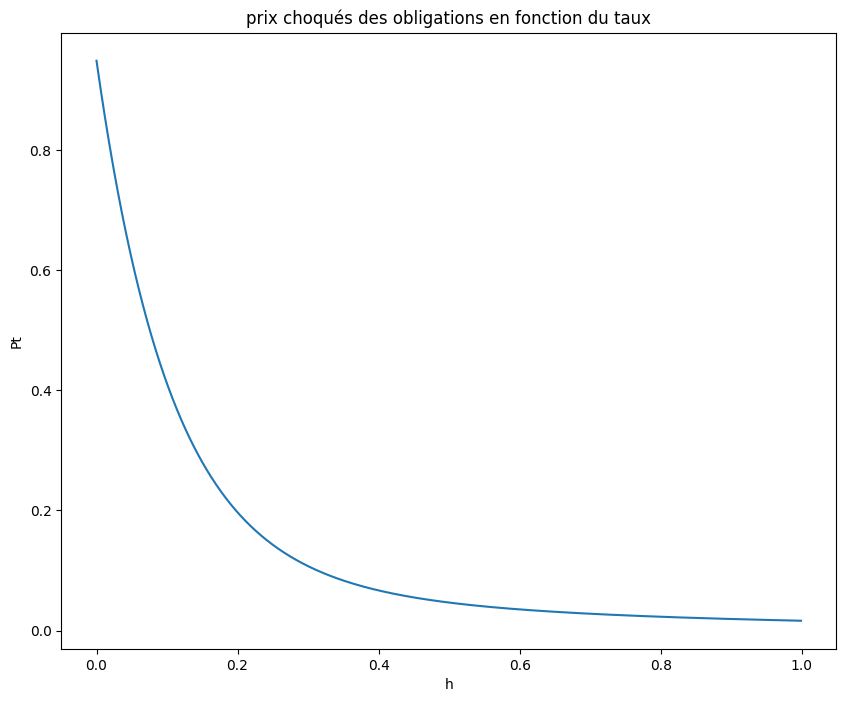

In [56]:
hs = np.arange(0, 1, 0.001) # liste des valeurs de h de 0 à 1 par pas de 0.001
prices_chocs = [ObligationPrice(0, c, s, T, data_fin, h = h0) for h0 in hs]

plt.figure(figsize = (10,8))
plt.plot(hs, prices_chocs)
plt.xlabel("h")
plt.ylabel("Pt")
plt.title('prix choqués des obligations en fonction du taux')
plt.show()

## Question 2: Comportement du prix en fonction du spread

On fait varier le spread entre 0 et 100% par pas de 0.1%. Nous représentons les prix obtenus.

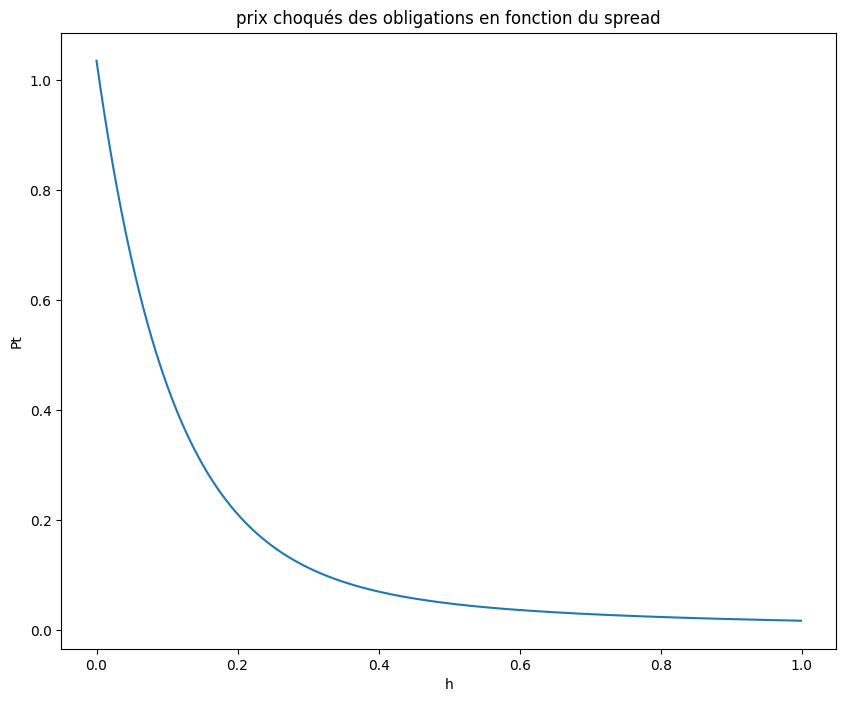

In [57]:
spreads = np.arange(0, 1, 0.001) # liste des valeurs du spread de 0 à 1 par pas de 0.001
prices_chocs_spreads = [ObligationPrice(0, c, spread, T, data_fin) for spread in spreads]

plt.figure(figsize = (10,8))
plt.plot(spreads, prices_chocs_spreads)
plt.xlabel("h")
plt.ylabel("Pt")
plt.title('prix choqués des obligations en fonction du spread')
plt.show()

## Question 3: Calcul de la duration par différences finies

Nous calculons maintenant la duration donnée par la formule:  
$D=-\frac{\partial P}{\partial r} / P$

Ainsi, il nous suffit de choisir un niveau de chocs des taux (h= 0.001 ici) et d'utiliser la méthode des différences finies pour estimer la variation du prix de l'obligation. 

In [58]:
h = 0.001
s = 0.01
c = 0.03
t = 0
T = 10
duration = -(ObligationPrice(t, c, s, T, data_fin, h = h) - ObligationPrice(t, c, s, T, data_fin))/(h*ObligationPrice(t, c, s, T, data_fin))
print(f"La duration calculée vaut {duration}")

La duration calculée vaut 8.708030151125548


# Valorisation de produit exotique avec HW1F

### Question 1

Le modéle Hull-white 1F s'écrit:
$$
B(t, T)=\frac{B(0, T)}{B(0, t)} e^{-\beta(t, T) X_t-\frac{1}{2} \beta^2(t, T) \phi(t)}
$$
avec :

$$
\begin{aligned}
& \phi(t)=e^{-2 \lambda t} \int_0^t \sigma_s^2 e^{2 \lambda s} d s \\
& \beta(t, T)=\frac{1-e^{-\lambda(T-t)}}{\lambda} \\
& \left.d X_t= (\phi(t)-\lambda X_t\right) d t+\sigma_t d W_t \quad ; \quad X_0=0
\end{aligned}
$$

Pour $\lambda=0$ et $\sigma_t=\sigma$ constant, on a:

$B(t, T) \approx T-t$ et $\phi(t)=\int_0^t \sigma^2 d s=\sigma^2 t$

On obtient donc
$$
\begin{aligned}
& B(t, T)=\frac{B(0, T)}{B(0, t)} \exp \left(-(T-t) X_t-\frac{1}{2}(T-t)^2 \sigma^2 t\right) \\
& d X_t=\sigma^2 t d t+\sigma d w_t \quad; \quad X_0=0
\end{aligned}
$$

### Question 2

#### Valorisation d'un caplet

Nous commençons par implémenter la fonction de Black qui calcul le prix d'une opion d'achat selon le modèle de Black (modèle de Black Scholes avec un taux d'intérêt nul).

In [59]:
import math
import numpy as np
from scipy.stats import norm

def black_call(F, K, T, sigma):
    d1 = (np.log(F / K) + (0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call = F * norm.cdf(d1) - K * norm.cdf(d2)
    return call

In [60]:
F = 1
K = 1
T = 1
sigma = 0.2
print(black_call(F, K, T, sigma))

0.07965567455405798


A l'aide de la fonction de Black nous pouvons calculer le prix d'un caplet sous le modèle HW1F et la valeur de marché du caplet. Les taux spot sont estimés grâce à une fonction d'interpolation construite sur les données dont nous disposons. Ensuite, dans chacune des deux fonctions (CapletPrice_HW, CapletPrice_market), nous appelons la fonction de Black avec les bons paramètres afin d'obtenir la valorisation désirée.

In [61]:
def CapletPrice_HW(sigma, T,  K, delta, data_taux): # Valeur du caplet sous le modèle HW1F
    interp_func = interpolate.interp1d(data_taux['T'], data_taux['B(0,T)'])
    B_0_T = interp_func(float(T))
    B_0T_delta = interp_func(float(T+delta))
    Fwd = B_0_T/B_0T_delta
    black = black_call(Fwd, K= 1+delta*K, T=T, sigma = sigma*delta)
    return B_0T_delta*black

def CapletPrice_market(T, vol_impl, K, delta, data_taux): # Valeur de marché du caplet
    interp_func = interpolate.interp1d(data_taux['T'], data_taux['B(0,T)'])
    B_0_T = interp_func(float(T))
    B_0T_delta = interp_func(float(T+delta))
    Fwd = (B_0_T/B_0T_delta-1)/delta
    black = black_call(Fwd, K= K, T=T, sigma = vol_impl)
    return delta*B_0T_delta*black

#### Calibration de $\sigma$

Pour calibrer $\sigma$, nous comparons le vrai prix du caplet au prix sous le modèle HW1F de sorte à minimiser par la suite l'erreur (nous considérons l'erreur quadratique). La fonction calibration_error permet de calculer l'erreur à minimiser. 

On prendra :

$K = 4\% $

$T = 10 ans$

$\delta= 0.5$

$\sigma_{impl} = 25\%$



In [62]:
def calibration_error(sigma, *args): # erreur d'estimation à minimiser 
    T, vol_impl, K, delta, data_taux = args
    model_price = CapletPrice_HW(sigma, T, K, delta, data_taux)
    market_price = CapletPrice_market(T, vol_impl, K, delta, data_taux)
    error = (model_price - market_price)**2
    return error
    

Nous minimisons la fonction précédente afin d'obtenir le paramètre $\sigma$ qui minimise l'erreur. Ce paramètre correspond alors au paramètre calibré. La variable initial_sigma correspond à la valeur de départ que nous donnons à notre fonction de minimisation pour la recherche de la meilleure valeur du paramètre. 

In [63]:
from scipy.optimize import minimize
initial_sigma = 0.2
K = 0.04
T = 10
delta = 0.5
vol_impl = 0.25
data_taux = data_fin

# Minimisation de la fonction d'erreur en ajustant sigma
result = minimize(calibration_error, initial_sigma, args=(T, vol_impl, K, delta, data_taux))

# Valeur calibrée de sigma
calibrated_sigma = result.x[0]

calibrated_sigma

0.008098474035498824

### Question 3

On a:
$$
L(i, i+1)=\frac{1}{\delta}\left(\frac{1}{B(i, i+1)}-1\right)
$$

Or, dans le cadre du modele HWIF:
$$
B(i, i+1)=\frac{B(0, i+1)}{B(0, i)} \exp \left(-X_i-\frac{1}{2} \sigma^2 i\right)
$$

Donc, en remplaçant la valeur de $B(i, i+1)$, on a:
$$
L(i, i+1)=\frac{1}{\delta}\left(\frac{B(0, i)}{B(0, i+1)} \exp \left(X_i+\frac{1}{2} \sigma^2 i\right)-1\right)
$$

### Question 4

Dans le cadre de cette question, nous procédons en deux étapes: 

- Simulations de plusieurs trajectoires du Libor sur la période considérée (maturité 10 ans)

- Calcul du prix du produit qui paie les flux $\frac{\sum_1^{10}{\mathbb{1}_{{L(i,i+1)>barriere}}}}{10}$. Pour cela il suffit de prendre une moyenne de ce que paie ces flux sur les différentes simulations Monte Carlo afin d'avoir une estimation de la moyenne des flux

#### Simulations du Libor

On commence par implémenter les simulations de X selon le modèle Hull White avec $\lambda =0$ et $\sigma$ constant. Nous avons à la suite implémenter une fonction de calcul du taux spot, elle permet d'interpoler la valeur du taux spot pour des maturités non présentes dans la base. Ces fonctions nous permettent d'implémenter la fonction de simulation de B(t, T) selon le modèle HW1F. Une fois la valeur de B(i, i+1) simulée, nous pouvons simuler celle de L(i,i+1), ce qui est fait dans la dernière fonction de la cellule.

Pour simuler X, nous nous servons de l'équation :

$d X_t=\sigma^2 t d t+\sigma d w_t \quad$

La résolution de l'équation fournit

$\begin{aligned} \Delta_{i \rightarrow i+1} X & =\sigma^2 \int_i^{i+1} t d t+\sigma \int_i^{i+1} d W_t \\ & =\sigma^2 \frac{(i+1)^2-i^2}{2}+\sigma N(0,1) \\ \Delta_{i \rightarrow i+1} X & =\sigma^2\left(i+\frac{1}{2}\right)+\sigma U\end{aligned}$

Grâce à cette formule nous obtenons les incréments qui nous permettent d'obtenir les différentes valeurs simulées de X pour chaque trajectoire.

In [64]:
np.random.seed(42)

def SimulX(sigma, T): # Simuler une trajectoire de X de longueur T sans compter la valeur initiale X0
    X = [0]
    U = np.random.normal(size = T)
    increments = [sigma**2*(i+0.5)+sigma*U[i] for i in range(T)] 
    for i in range(T):
        X.append(X[-1]+increments[i]) 
    return X

def calculB_0T(T, data_taux):
    interp_func = interpolate.interp1d(data_taux['T'], data_taux['B(0,T)'])
    B_0_T = interp_func(float(T))
    return B_0_T

def simulB(t1, t2, sigma, X, data_taux):
    return calculB_0T(t2, data_taux)*np.exp(-(t2-t1)*X[t1]-((t2-t1)**2)*(sigma**2)*t1/2)/calculB_0T(t1, data_taux)
    
def simulLibor(index, sigma, delta, X, data_taux):
    B_i = simulB(index, index+1, sigma, X, data_taux)
    return (1/B_i - 1)/delta
    


#### Prix du produit

Nous disposons de la fonction qui permet de simuler une valeur du Libor, repétons le processus plusieurs fois afin de valoriser le produit considéré. La valeur obtenu est ensuite actualisée grâce au taux spot.

$\sigma$: Valeur calibrée de la question 2

$T = 10 ans$

$\delta = 0.5$

$barriere = 3\%$


In [65]:
def PriceMC(T, n_simul, sigma, delta, data_taux, bar):
    values = []
    for i in range(n_simul):
        X = SimulX(sigma, T)
        simulsLib = [simulLibor(index0, sigma, delta, X, data_taux) for index0 in range(1,T+1)]
        value = len([lib for lib in simulsLib if lib >bar])/T
        values.append(value)
    return np.mean(values)*calculB_0T(T, data_taux)



In [66]:
n_simul = 5000
sigma = calibrated_sigma
T = 10
delta = 0.5
bar = 0.03
prix = PriceMC(T, n_simul, sigma, delta, data_taux, bar)
print(f"Le prix du produit est {prix}")

Le prix du produit est 0.5693705359644288


Nous pouvons représenter l'évolution du prix, en fonction de la barrière. Le prix est décroissant en fonction de la barrière et tend vers 0. Nous nous y attendions car au fur et à mesure que la barrière augmente le Libor dépassera de moins en moins cette barrière et donc le produit paiera moins à la maturité.  

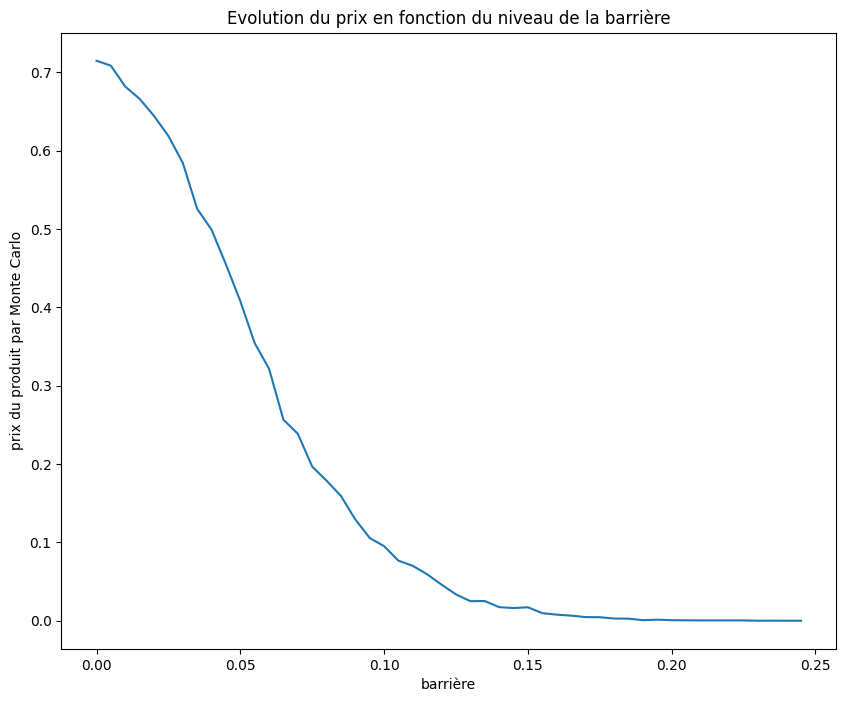

In [67]:
n_simul = 1000
bars = np.arange(0, 0.25, 0.005)
MCprices = [PriceMC(T, n_simul, sigma, delta, data_taux, bar0) for bar0 in bars]

plt.figure(figsize=(10,8))
plt.plot(bars, MCprices)
plt.xlabel("barrière")
plt.ylabel("prix du produit par Monte Carlo")
plt.title('Evolution du prix en fonction du niveau de la barrière')
plt.show()

# Valorisation des obligations avec clause de rappel avec Hull-White 1F (bonus)

## Question 1

Nous avons montré précédemment que le modelle HW se dégénérait, pour $\lambda=0$ et $\sigma_t=\sigma$ constant comme suit :
$$
\begin{aligned}
B(t, T) & =\frac{B(0, T)}{B(0, t)} \exp \left(-(T-t) X_t-\frac{1}{2}(T-t)^2 \sigma^2 t\right) \\
d X_t & =\sigma^2 t d t+\sigma d W_t
\end{aligned}
$$

En intégrant $X_t$, nous avons:
$$
\begin{aligned}
& X_t=\int \sigma^2 t d t+\int \sigma d W_t \\
& X_t=\frac{1}{2} \sigma^2 t^2+\sigma W_t+c \quad \text { avec } W_t \sim N(0, t)
\end{aligned}
$$

De plus,
$$
X_0=\sigma W_0+c=0 \quad \text { où } W_0 \sim N(0,0)=0
$$
donc $c=0$

Par conséquent,
$$
X_t=\frac{1}{2} \sigma^2 t^2+\sigma W_t \text { avec } W_t \sim N(0, t)
$$

Ainsi $W_t=\sqrt{t} U$ où $U \sim N(0,1)$

Il vient donc:
$$
\begin{aligned}
& B(t, T, U, \sigma)=\frac{B(0, T)}{B(0, t)} \exp \left(-(T-t)\left(\frac{1}{2} \sigma^2 t^2+\sigma \sqrt{t} U\right)-\frac{1}{2}(T-t)^2 \sigma^2 t\right)
\end{aligned}
$$
$$
\text { avec } U \sim N(0,1)
$$

## Question 2: Fonction de valorisation

Pour implémenter la fonction de valorisation, nous commençons par implémenter une fonction "calculB" qui caalcule B selon la formule démontrée à la question précédente avec les paramètres correspondant. Nous ajoutons également un paramètre qui va servir à choquer la courbe de taux, au besoin.

Ensuite nous implémentons la fonction de valorisation "calculP". Elle est semblable à la fonction "ObligationPrice" utilisée pour la valorisation d'une obligation simple, à la différence que la fonction "calculP" utilise plusieurs simulations de Monte Carlo (à travers l'argument U qui est une liste de réalisations de la loi normale centrée réduite). On prend ensuite la moyenne des valeurs obtenues à partir des différentes simulations. Aussi, la fonction "calculP" utilise la fonction calculB pour le calcul du taux.

In [68]:

def calculB(t, T, U, sigma, data_taux, h=0):
    B1 = calculB_0T(T, data_taux)*np.exp(-h*t)
    B2 = calculB_0T(t, data_taux)*np.exp(-h*t)
    term = np.exp(-(T-t)*(0.5*(sigma**2)*(t**2)+sigma*np.sqrt(t)*U)-0.5*((T-t)**2)*(sigma**2)*t)
    return B1*term/B2

def calculP(t, T, sigma, c, s, data_taux, n_simul, U, h=0):
    termes = []
    for k in range(n_simul):
    
        terme = 0
        for i in range(1, T+1):
            if t<i :
                terme += c*calculB(t, i, U[k], sigma, data_taux, h=h)*calcul_PS(i, s, t)
        if t<T:
            terme += calculB(t, T, U[k], sigma, data_taux, h=h)*calcul_PS(T, s, t)
        termes.append(terme)
    result = sum(termes)/n_simul
    return result

## Question 3

Nous implémentons une fonction qui simule un (seul) prix grâce à la fonction de valorisation précédante (le nombre de simulations est fixé à 1) et qui retourne le minimum entre 1 et ce prix. 

In [69]:
def retainedP(t, T, sigma, c, s, data_taux, U, h=0):
    price = calculP(t, T, sigma, c, s, data_taux, 1, U, h=h)
    if price>1:
        return 1
    else: 
        return price

## Question 4

Grâce à la fonction précédante, nous calculons la moyenne arithmétique des valeurs retenues où la valeur retenue est le minimum entre le prix et 1 sur une simulation. Ce calcul nous permet d'obtenir la valeur de l'obligation avec clause de rappel. 

In [70]:

def calculPc(t, T, sigma, c, s, data_taux, n_simul, U, h=0):
    retainedPs = [retainedP(t, T, sigma, c, s, data_taux, [U[k]]) for k in range(n_simul)]

    return float(sum(retainedPs)/n_simul)


## Question 5: Prix de l'option

Le prix de l'option est obtenu en actualisant la différence de prix entre le prix de l'obligation sans clause de rappel et le prix avec clause de rappel.
Nous commençons par simuler des réalistions de la loi normale centrée réduite, ces réalistions nous permettent ensuite de simuler les valeurs de prix sans clause de rappel et les comparer à la moyenne arithmétique de leur minimum avec 1. Les valeurs sont comparables car le vecteur U est commun au calcul des prix sans clause de rappel et à celui des prix avec clause de rappel.

Nous calculons le prix de l'option pour:

$T = 10 ans$

$t = 5 ans$

$\sigma = 1\%$

$c = 3\%$

$s = 1\%$

$10000$ simulations

In [71]:
def calculOption(t, T, sigma, c, s, data_taux, n_simul, h=0):
    U = np.random.randn(n_simul)
    P = calculP(t, T, sigma, c, s, data_taux, n_simul, U, h=h)
    Pc = calculPc(t, T, sigma, c, s, data_taux, n_simul, U, h=h)
    return calculB_0T(t, data_taux)*(P-Pc)

In [72]:
T = 10
t = 5
sigma = 0.01
c = 0.03
s = 0.01
n_simul = 10000
opt = calculOption(t, T, sigma, c, s, data_taux, n_simul)
print(f"Le prix de l'option vaut: {opt}")

Le prix de l'option vaut: 0.023531117925809465


## Question 6

Calcul du prix de l'option pour différentes valeurs de $\sigma$ et comportement du prix de l'option

In [73]:
sigmas = np.arange(0, 0.0525, 0.0025) # sigma dans {0, 0.25%, 0.5%,..., 5%}
opts = [calculOption(t, T, sigm, c, s, data_taux, n_simul) for sigm in sigmas]
results = pd.DataFrame({"sigma": sigmas,
                        "Prix de l'option": opts})
results

,sigma,Prix de l'option
0,0.0000,0.000000
1,0.0025,0.001330
2,0.0050,0.007638
3,0.0075,0.014870
4,0.0100,0.023245
5,0.0125,0.028763
6,0.0150,0.037826
7,0.0175,0.044263
8,0.0200,0.051473
9,0.0225,0.057907


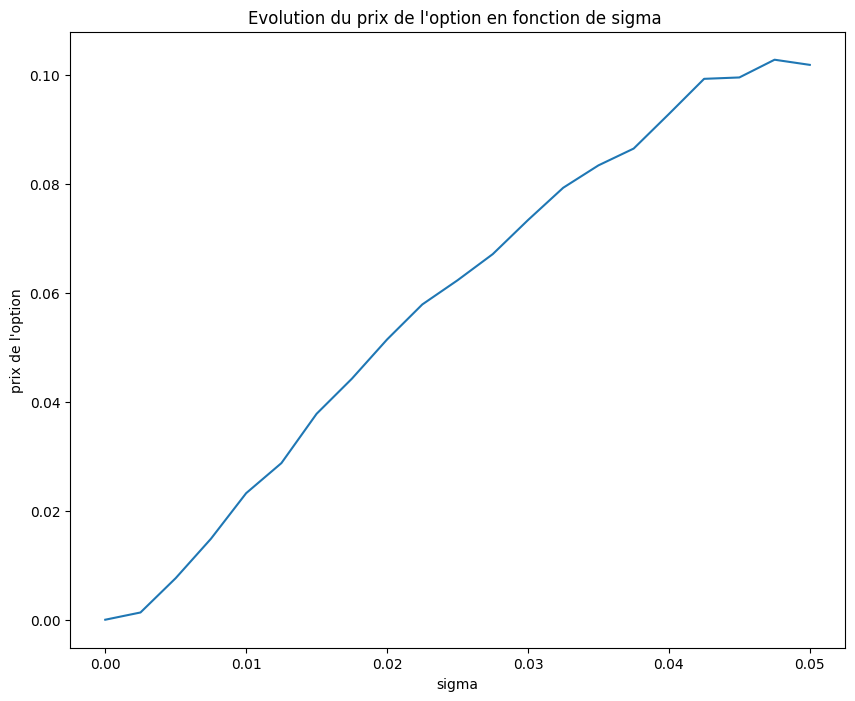

In [74]:
plt.figure(figsize=(10,8))
plt.plot(sigmas, opts)
plt.xlabel("sigma")
plt.ylabel("prix de l'option")
plt.title("Evolution du prix de l'option en fonction de sigma ")
plt.show()

## Question 7

Calcul du prix de l'option pour différentes valeurs de $t$ et comportement du prix de l'option

In [75]:
ts = np.arange(1,10,1) # t dans {1, 2, 3, 4, ..., 9}
opts_t = [calculOption(t0, T, sigma, c, s, data_taux, n_simul) for t0 in ts]
results_t = pd.DataFrame({"t": ts,
                        "Prix de l'option": opts_t})
results_t

,t,Prix de l'option
0,1,0.015126
1,2,0.021710
2,3,0.025150
3,4,0.024784
4,5,0.022048
5,6,0.019651
6,7,0.015511
7,8,0.010898
8,9,0.005565


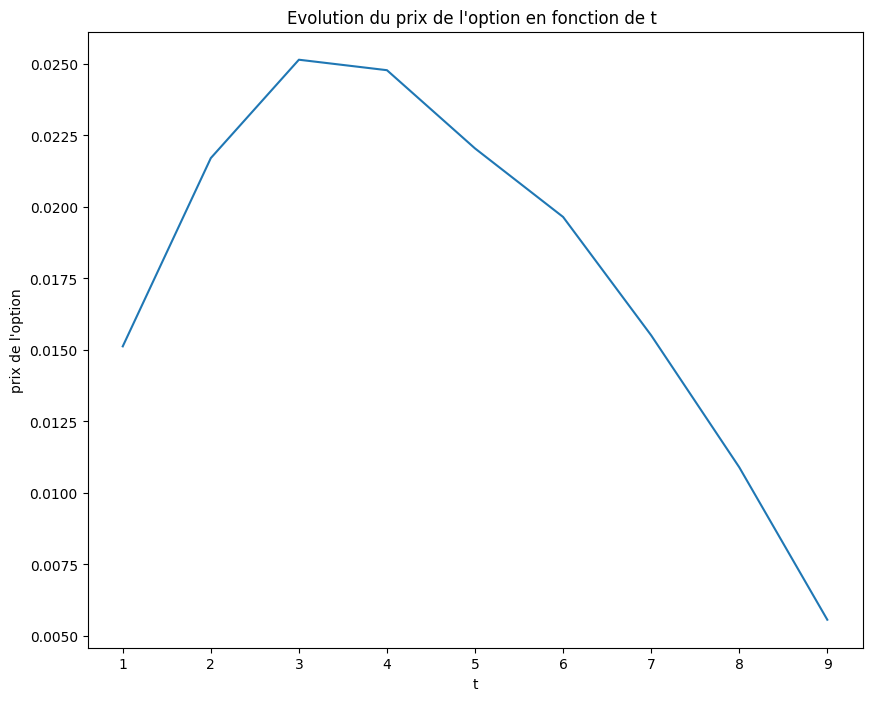

In [76]:
plt.figure(figsize=(10,8))
plt.plot(ts, opts_t)
plt.xlabel("t")
plt.ylabel("prix de l'option")
plt.title("Evolution du prix de l'option en fonction de t ")
plt.show()

## Question 8 : Calcul du delta et du vega

Nous utilisons la méthode des différences finies. Pour le calcul du delta, il suffit de choquer la courbe de taux tandis que pour le calcul du vega, il suffit de choquer $\sigma$.

Les formules correspondantes sont:

$$
\begin{aligned}
& \Delta = \frac{Option(t, T, U, \sigma, h=h_0) - Option(t, T, U, \sigma, h=0)}{h_0}\\
& Vega = \frac{Option(t, T, U, \sigma + \sigma_0) - Option(t, T, U, \sigma)}{\sigma_0}\\
\end{aligned}
$$

Avec Option le prix de l'option, $h_0$ le choc appliqué à la courbe de taux (nous choisissons ici $h_0$ = 0.1%) et $\sigma_0$ le choc appliqué à $\sigma$ (nous choisissons ici $\sigma_0$ = 0.1%)

In [79]:
h = 0.001
n_simul = 10000
option0 = calculOption(t, T, sigma, c, s, data_taux, n_simul)
optionh = calculOption(t, T, sigma, c, s, data_taux, n_simul, h=h)
delta = (optionh-option0)/h

print(f"Le delta de cette option vaut: {delta}")

Le delta de cette option vaut: 1.0822893302750194


In [80]:
sigmah = 0.001
optionsigma0 = calculOption(t, T, sigma, c, s, data_taux, n_simul)
optionsigmah = calculOption(t, T, sigma+sigmah, c, s, data_taux, n_simul)
vega = (optionsigmah-optionsigma0)/sigmah

print(f"Le vega de cette option vaut: {vega}")

Le vega de cette option vaut: 3.700944592157217
